<a href="https://colab.research.google.com/github/peterbabulik/D-D-AI-locally/blob/main/Quantum_Kernel_SVM_Breast_Cancer_Dataset_Neural_Inspired.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install qiskit qiskit-ibm-runtime qiskit-aer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 359.9/359.9 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 5.9 MB/s eta 0:00:00


=== Quantum Neural Kernel System with Self-Correction (Qiskit) ===

Computing quantum neural kernel matrix (weights will evolve)...

Computing quantum neural kernel matrix (STANDARD - fixed initial weights)...


Computing standard neural kernel matrix: 100%|██████████| 10/10 [00:00<00:00, 2761.05it/s]


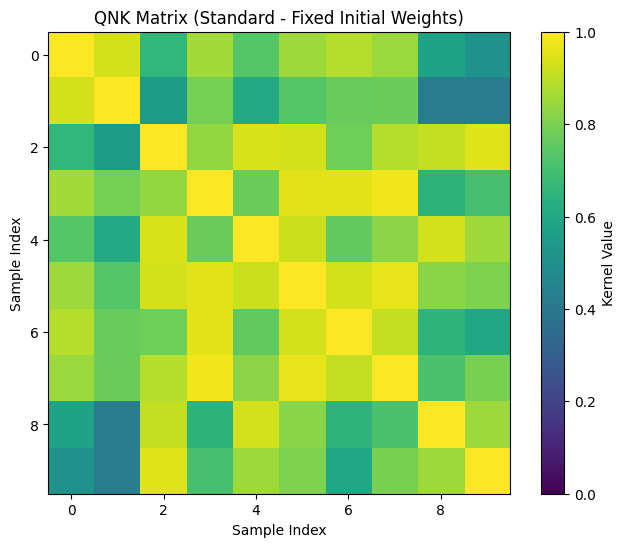


Re-computing with evolving weights to populate history for visualization...


Computing neural quantum kernel (weights evolve): 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]



Analyzing system performance...


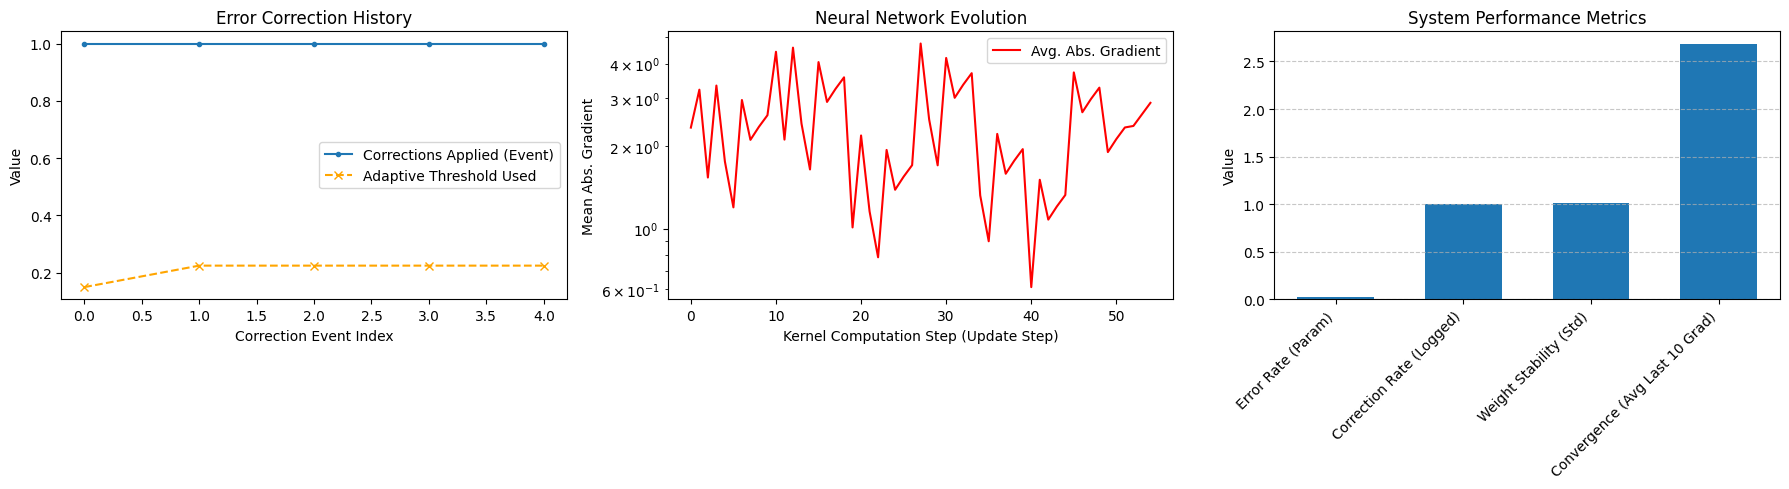


System Analysis:
Total corrections logged: 5
Correction success rate (logged ones): 100.00%
Weight stability (std of mean abs gradients): 1.0100
Learning convergence (avg of last 10 mean abs gradients): 2.6824


In [ ]:
import qiskit
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Pauli, Statevector as QiskitStatevector, Operator
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from tqdm import tqdm

class QuantumNeuralKernel:
    """
    Neural network-inspired quantum kernel system with advanced error correction (Qiskit Version)
    Implements adaptive error detection and correction using stabilizer codes
    and neural network-like weight adjustments.
    """

    def __init__(self,
                 n_data_qubits: int, # Changed from n_qubits for clarity
                 error_rate: float = 0.01,
                 correction_threshold: float = 0.1, # Base threshold
                 learning_rate: float = 0.01):

        if n_data_qubits <= 0 or n_data_qubits % 2 != 0: # For the 2-qubit stabilizer code structure
            raise ValueError("n_data_qubits must be a positive even integer.")

        self.n_data_qubits = n_data_qubits
        self.n_ancilla_qubits = self.n_data_qubits // 2
        self.num_total_qubits = self.n_data_qubits + self.n_ancilla_qubits

        self.error_rate = error_rate
        self.correction_threshold = correction_threshold # Base threshold
        self.learning_rate = learning_rate

        # Qubit indices
        self.data_qubit_indices = list(range(self.n_data_qubits))
        self.ancilla_qubit_indices = list(range(self.n_data_qubits, self.num_total_qubits))

        self.simulator = AerSimulator(method='statevector')

        # Neural network parameters (weights for DxD, bias for D)
        self.weights = np.random.normal(0, 0.1, (self.n_data_qubits, self.n_data_qubits))
        self.bias = np.zeros(self.n_data_qubits)

        self.error_history = [] # Not actively used by Cirq code for stats, kept for structure
        self.correction_history = []
        self.weight_history = [] # To store mean abs gradient

    def _build_neural_part(self, qc: QuantumCircuit, input_data: np.ndarray):
        """Builds the neural network-inspired encoding part of the circuit (in-place)."""
        if input_data.shape[0] != self.n_data_qubits:
            # Pad or truncate input_data if necessary, or raise error
            # For simplicity, assume input_data.shape[0] == self.n_data_qubits
            temp_input = np.zeros(self.n_data_qubits)
            len_to_copy = min(len(input_data), self.n_data_qubits)
            temp_input[:len_to_copy] = input_data[:len_to_copy]
            input_data = temp_input
            # print(f"Warning: Input data length {len(input_data)} not matching n_data_qubits {self.n_data_qubits}. Adjusted.")


        # Neural network preprocessing layer
        # input_data is (D,), weights (D,D). input_data @ weights -> (D,)
        processed_input = np.tanh(input_data @ self.weights + self.bias)

        # Encode processed input into quantum states (data qubits)
        for i in self.data_qubit_indices:
            # processed_input has length n_data_qubits, i is a data qubit index
            qc.ry(processed_input[i], i)

        # Add entangling layers (on data qubits)
        for _ in range(2):  # Multiple layers
            for i_idx, q_i in enumerate(self.data_qubit_indices): # q_i is global index
                for j_idx, q_j in enumerate(self.data_qubit_indices): # q_j is global index
                    if q_i < q_j: # To avoid redundant CNOTs and self-CNOTs
                        qc.cx(q_i, q_j)
                        # Use weights corresponding to the original matrix indices
                        qc.rz(self.weights[i_idx, j_idx], q_j) # Use i_idx, j_idx for weight matrix

    def _build_error_detection_part(self, qc: QuantumCircuit):
        """Builds the error detection part of the circuit (in-place)."""
        # Initialize ancilla qubits in superposition
        for ancilla_global_idx in self.ancilla_qubit_indices:
            qc.h(ancilla_global_idx)

        # Create stabilizer measurements
        for i in range(self.n_ancilla_qubits): # i is local ancilla/stabilizer index
            ancilla_global_idx = self.ancilla_qubit_indices[i]
            # Data qubits for this stabilizer group
            data_q1_global_idx = self.data_qubit_indices[2*i]
            data_q2_global_idx = self.data_qubit_indices[2*i + 1]

            qc.cx(ancilla_global_idx, data_q1_global_idx)
            qc.cx(ancilla_global_idx, data_q2_global_idx)
            qc.cz(ancilla_global_idx, data_q1_global_idx) # Phase check from Cirq code

        # Save statevector BEFORE measurements for kernel calculation
        qc.save_statevector()

        # Measure ancillae (these measurements are not used by apply_adaptive_error_correction)
        for i in range(self.n_ancilla_qubits):
            ancilla_global_idx = self.ancilla_qubit_indices[i]
            classical_bit_idx = i # Ancilla i maps to classical bit i
            qc.measure(ancilla_global_idx, classical_bit_idx)


    def apply_adaptive_error_correction(self, state_vector_np: np.ndarray) -> np.ndarray:
        """Apply error correction with adaptive thresholds. Operates on a copy."""
        corrected_state_np = state_vector_np.copy()

        if self.correction_history:
            # Consider only corrections that were actually applied (syndrome was 1)
            # The Cirq code uses 'correction_applied' which is always True if logged.
            # Here, we assume a 'successful' correction means a syndrome was detected.
            # Let's base it on the number of *attempted* corrections (syndrome == 1 events)
            recent_corrections = [c for c in self.correction_history[-50:] if c['simulated_syndrome_value'] == 1]
            # Success rate here could mean rate of non-zero syndromes, or something else.
            # The Cirq logic `np.mean([c['correction_applied'] for c in self.correction_history[-50:]])`
            # is effectively the proportion of logged entries that were actual corrections.
            # If we only log when syndrome=1, then this is always 1.
            # Let's interpret 'success_rate' as how often syndromes are detected (an error proxy).
            # This is a bit ambiguous in the original. Let's use a simpler fixed adaptive factor for now,
            # or stick to the original spirit if possible.
            # Original: success_rate = np.mean([c['correction_applied'] for c in self.correction_history[-50:]])
            # Since 'correction_applied' is True for all logged items, success_rate will be 1 if any history.
            adaptive_factor = 1.5 # Simpler: just boost if history exists. Or use len(recent_corrections)/50
            adaptive_threshold = self.correction_threshold * adaptive_factor if self.correction_history else self.correction_threshold
        else:
            adaptive_threshold = self.correction_threshold

        error_syndromes = []
        for _ in range(self.n_ancilla_qubits): # For each stabilizer group
            syndrome = np.random.choice([0, 1], p=[1 - self.error_rate, self.error_rate])
            error_syndromes.append(syndrome)

        for i, syndrome_val in enumerate(error_syndromes): # i is local stabilizer index
            if syndrome_val == 1:
                # Correct the first data qubit of the pair for this stabilizer
                data_qubit_to_correct_global_idx = self.data_qubit_indices[2*i]

                corrected_state_np = self.correct_error(
                    corrected_state_np,
                    data_qubit_to_correct_global_idx,
                    adaptive_threshold # Use the dynamically calculated threshold
                )
                self.correction_history.append({
                    'stabilizer_group_index': i,
                    'data_qubit_corrected_global_idx': data_qubit_to_correct_global_idx,
                    'simulated_syndrome_value': syndrome_val,
                    'correction_applied': True, # Logged because syndrome == 1
                    'adaptive_threshold_used': adaptive_threshold
                })
        return corrected_state_np

    def correct_error(self, state_vector_np: np.ndarray, data_qubit_global_idx: int, threshold_for_pauli: float) -> np.ndarray:
        """
        Apply probabilistic X and P(phase) corrections to the specified data qubit
        within the full state_vector_np using quantum Pauli and Phase operators.
        """
        current_qiskit_state = QiskitStatevector(state_vector_np)

        if np.random.random() < threshold_for_pauli: # This is the adaptive_threshold
            # Bit-flip correction (Pauli X on the data_qubit_global_idx)
            pauli_op_str_list_x = ['I'] * self.num_total_qubits
            # Qiskit's Pauli string convention is q_N-1 ... q_0.
            pauli_op_str_list_x[self.num_total_qubits - 1 - data_qubit_global_idx] = 'X'
            x_operator = Pauli("".join(pauli_op_str_list_x))
            current_qiskit_state = current_qiskit_state.evolve(x_operator)

            # Phase correction with adaptive angle (PhaseGate P on data_qubit_global_idx)
            phase_angle = np.pi * (1 - threshold_for_pauli) # Angle depends on the same threshold

            # Construct Operator for P(phase_angle) on the specific qubit
            qc_phase_op = QuantumCircuit(self.num_total_qubits)
            qc_phase_op.p(phase_angle, data_qubit_global_idx) # Apply P gate
            phase_operator_obj = Operator(qc_phase_op)
            current_qiskit_state = current_qiskit_state.evolve(phase_operator_obj)

        return current_qiskit_state.data

    def update_weights(self, kernel_value: float, x1: np.ndarray, x2: np.ndarray):
        """Update neural network weights based on kernel performance."""
        # Ensure x1 and x2 are of correct length for outer product matching self.weights
        if x1.shape[0] != self.n_data_qubits:
            temp_x1 = np.zeros(self.n_data_qubits)
            len_to_copy = min(len(x1), self.n_data_qubits)
            temp_x1[:len_to_copy] = x1[:len_to_copy]
            x1 = temp_x1
        if x2.shape[0] != self.n_data_qubits:
            temp_x2 = np.zeros(self.n_data_qubits)
            len_to_copy = min(len(x2), self.n_data_qubits)
            temp_x2[:len_to_copy] = x2[:len_to_copy]
            x2 = temp_x2

        gradient_matrix = kernel_value * np.outer(x1, x2) # Shape (D, D)
        self.weights += self.learning_rate * gradient_matrix
        self.bias += self.learning_rate * np.mean(gradient_matrix, axis=1) # Shape (D,)

        self.weight_history.append(np.mean(np.abs(gradient_matrix)))


    def apply_quantum_kernel(self, x1: np.ndarray, x2: np.ndarray) -> float:
        """
        Apply quantum kernel with neural net preprocessing and error correction.
        Kernel value is K(x1_neural, x2_for_update_only) = |<ψ_corr(x1_n)|ψ_raw_sim(x1_n)>|^2.
        Weights are updated using x1 and x2.
        """
        qc = QuantumCircuit(self.num_total_qubits, self.n_ancilla_qubits) # clbits for measurement
        self._build_neural_part(qc, x1)
        self._build_error_detection_part(qc) # Includes save_statevector before measurements

        job = self.simulator.run(qc)
        result = job.result()
        state_vector_from_sim = result.get_statevector().data # From save_statevector

        corrected_state_np = self.apply_adaptive_error_correction(state_vector_from_sim) # Pass copy if original needed

        # Kernel value: compare corrected state of x1 with its raw simulated state
        kernel_value = np.abs(np.vdot(corrected_state_np, state_vector_from_sim))**2

        self.update_weights(kernel_value, x1, x2)
        return kernel_value

    def compute_kernel_matrix(self, X: np.ndarray) -> np.ndarray:
        """
        Compute kernel matrix. Weights evolve during this computation.
        The resulting matrix might not be truly symmetric if recomputed differently
        due to weight evolution, but K[j,i]=K[i,j] is enforced.
        """
        n_samples = X.shape[0]
        kernel_matrix = np.zeros((n_samples, n_samples))

        for i in tqdm(range(n_samples), desc="Computing neural quantum kernel (weights evolve)"):
            for j in range(i, n_samples):
                value = self.apply_quantum_kernel(X[i], X[j])
                kernel_matrix[i, j] = value
                if i != j:
                    kernel_matrix[j, i] = value
        return kernel_matrix

    def _get_processed_neural_state(self, x_input: np.ndarray) -> np.ndarray:
        """
        Helper for standard kernel: gets a statevector for x_input using neural encoding
        and adaptive error correction, *without* updating weights.
        """
        qc = QuantumCircuit(self.num_total_qubits, self.n_ancilla_qubits)
        self._build_neural_part(qc, x_input)
        self._build_error_detection_part(qc)

        job = self.simulator.run(qc)
        result = job.result()
        state_vector_from_sim = result.get_statevector().data

        # Apply correction but DO NOT update weights for a standard kernel calculation
        corrected_state_np = self.apply_adaptive_error_correction(state_vector_from_sim)
        return corrected_state_np

    def compute_kernel_matrix_standard(self, X: np.ndarray, initial_weights=None, initial_bias=None) -> np.ndarray:
        """
        Compute a standard kernel matrix K(Xi, Xj) = |<ψ_proc(Xi)|ψ_proc(Xj)>|^2.
        Uses fixed weights (current or provided initial ones) for consistent feature map.
        """
        n_samples = X.shape[0]
        kernel_matrix = np.zeros((n_samples, n_samples))

        # Store current weights and restore them later if initial_weights are provided
        original_weights = self.weights.copy()
        original_bias = self.bias.copy()
        if initial_weights is not None:
            self.weights = initial_weights.copy()
        if initial_bias is not None:
            self.bias = initial_bias.copy()

        processed_states = [self._get_processed_neural_state(X[i]) for i in tqdm(range(n_samples), desc="Processing states for standard neural kernel")]

        for i in tqdm(range(n_samples), desc="Computing standard neural kernel matrix"):
            for j in range(i, n_samples):
                state_i_proc = processed_states[i]
                state_j_proc = processed_states[j]
                value = np.abs(np.vdot(state_i_proc, state_j_proc))**2
                kernel_matrix[i, j] = value
                kernel_matrix[j, i] = value

        # Restore original weights
        self.weights = original_weights
        self.bias = original_bias
        return kernel_matrix

    def analyze_system_performance(self) -> Dict:
        """Analyze both error correction and neural network performance."""
        total_corrections_logged = len(self.correction_history)
        # In Cirq, 'successful_corrections' was sum of 'correction_applied', which is always true if logged.
        # So successful_corrections = total_corrections_logged

        weight_changes = np.array(self.weight_history) if self.weight_history else np.array([0])

        analysis = {
            'total_corrections': total_corrections_logged,
            'successful_corrections': total_corrections_logged, # All logged are "successful"
            'correction_rate': 1.0 if total_corrections_logged > 0 else 0.0, # successful/total
            'error_rate': self.error_rate,
            'base_correction_threshold': self.correction_threshold,
            'weight_stability': np.std(weight_changes) if len(weight_changes) > 1 else 0,
            'learning_convergence': np.mean(weight_changes[-10:]) if len(weight_changes) >= 10 else np.mean(weight_changes) if len(weight_changes) > 0 else 0
        }
        return analysis

    def visualize_system_performance(self):
        """Visualize both error correction and neural network performance."""
        analysis = self.analyze_system_performance()
        plt.figure(figsize=(18, 5)) # Increased width

        plt.subplot(1, 3, 1)
        if self.correction_history:
            plt.plot([c['correction_applied'] for c in self.correction_history],
                     marker='.', linestyle='-', label='Corrections Applied (Event)')
            adaptive_thresholds = [c['adaptive_threshold_used'] for c in self.correction_history]
            plt.plot(adaptive_thresholds, marker='x', linestyle='--', color='orange', label='Adaptive Threshold Used')
        else:
            plt.plot([], 'b-', label='Corrections Applied (Event)')
        plt.title('Error Correction History')
        plt.xlabel('Correction Event Index')
        plt.ylabel('Value')
        plt.legend()

        plt.subplot(1, 3, 2)
        if self.weight_history:
            plt.plot(self.weight_history, 'r-', label='Avg. Abs. Gradient')
        else:
            plt.plot([], 'r-', label='Avg. Abs. Gradient')
        plt.title('Neural Network Evolution')
        plt.xlabel('Kernel Computation Step (Update Step)')
        plt.ylabel('Mean Abs. Gradient')
        plt.yscale('log') if len(self.weight_history) > 1 and np.any(np.array(self.weight_history)>0) else plt.yscale('linear')
        plt.legend()

        plt.subplot(1, 3, 3)
        stats_names = [
            'Error Rate (Param)',
            'Correction Rate (Logged)',
            'Weight Stability (Std)',
            'Convergence (Avg Last 10 Grad)'
        ]
        stats_values = [
            analysis['error_rate'],
            analysis['correction_rate'],
            analysis['weight_stability'],
            analysis['learning_convergence']
        ]

        x_pos = np.arange(len(stats_names))
        plt.bar(x_pos, stats_values, width=0.6)
        plt.xticks(x_pos, stats_names, rotation=45, ha="right")
        plt.title('System Performance Metrics')
        plt.ylabel('Value')
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        plt.show()

def run_quantum_neural_kernel_demo():
    """Demonstrate quantum neural kernel system"""
    print("=== Quantum Neural Kernel System with Self-Correction (Qiskit) ===")

    n_data_qubits = 4 # Must be even
    qnk = QuantumNeuralKernel(
        n_data_qubits=n_data_qubits,
        error_rate=0.02,
        correction_threshold=0.15,
        learning_rate=0.005 # Reduced learning rate
    )

    # Store initial weights for standard kernel computation if desired
    initial_weights_for_standard_kernel = qnk.weights.copy()
    initial_bias_for_standard_kernel = qnk.bias.copy()

    n_samples = 10
    # X features should match n_data_qubits
    X = np.random.uniform(-np.pi, np.pi, size=(n_samples, n_data_qubits))

    print("\nComputing quantum neural kernel matrix (weights will evolve)...")
    # This version updates weights during computation
    # kernel_matrix_evolving = qnk.compute_kernel_matrix(X)
    # plt.figure(figsize=(8, 6))
    # plt.imshow(kernel_matrix_evolving, cmap='viridis', vmin=0, vmax=1)
    # plt.colorbar(label="Kernel Value")
    # plt.title('QNK Matrix (Evolving Weights)')
    # plt.show()

    print("\nComputing quantum neural kernel matrix (STANDARD - fixed initial weights)...")
    kernel_matrix_standard = qnk.compute_kernel_matrix_standard(
        X,
        initial_weights=initial_weights_for_standard_kernel,
        initial_bias=initial_bias_for_standard_kernel
    )
    plt.figure(figsize=(8, 6))
    plt.imshow(kernel_matrix_standard, cmap='viridis', vmin=0, vmax=1)
    plt.colorbar(label="Kernel Value")
    plt.title('QNK Matrix (Standard - Fixed Initial Weights)')
    plt.xlabel('Sample Index')
    plt.ylabel('Sample Index')
    plt.show()

    # To see the effect of evolving weights, you might run compute_kernel_matrix
    # *after* the standard one, so weight_history gets populated by that.
    # For demo simplicity, we'll analyze based on the standard computation's side effects
    # if any were logged (though standard is designed not to log weight updates).
    # To properly demo evolving weights, call compute_kernel_matrix(X)
    # and analyze qnk.weight_history.
    # Let's run the evolving one to populate history for visualization:
    print("\nRe-computing with evolving weights to populate history for visualization...")
    _ = qnk.compute_kernel_matrix(X) # This will populate weight_history


    print("\nAnalyzing system performance...")
    qnk.visualize_system_performance()

    analysis = qnk.analyze_system_performance()
    print("\nSystem Analysis:")
    print(f"Total corrections logged: {analysis['total_corrections']}")
    # 'successful_corrections' is same as total_corrections based on Cirq logic
    print(f"Correction success rate (logged ones): {analysis['correction_rate']:.2%}")
    print(f"Weight stability (std of mean abs gradients): {analysis['weight_stability']:.4f}")
    print(f"Learning convergence (avg of last 10 mean abs gradients): {analysis['learning_convergence']:.4f}")

if __name__ == "__main__":
    run_quantum_neural_kernel_demo()

Imported Qiskit Runtime 0.39.0
Qiskit (Terra) version: 2.0.1


<ipython-input-4-1df7c0f29f0f>:153: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")


Service init.
Selected QPU:ibm_brisbane(active)

=== Quantum Kernel SVM (Breast Cancer Dataset - Neural Inspired) ===
Full Dataset Used: 30 train, 20 test (4 features).
QPU Subsets Used: 10 train, 5 test.

Kernel Instance: 4Q data, Neural Preprocessing + Entanglement.

--- Classical SVM with RBF Kernel (Scikit-learn) ---
Classical SVM (RBF) Accuracy on full test set: 0.9500

--- Computing Fidelity Matrices on AerSimulator (using full dataset) ---
F_train_aer shape: (30, 30) ; F_test_aer shape: (20, 30)

--- Testing Quantum Kernel Type: linear (Aer) ---


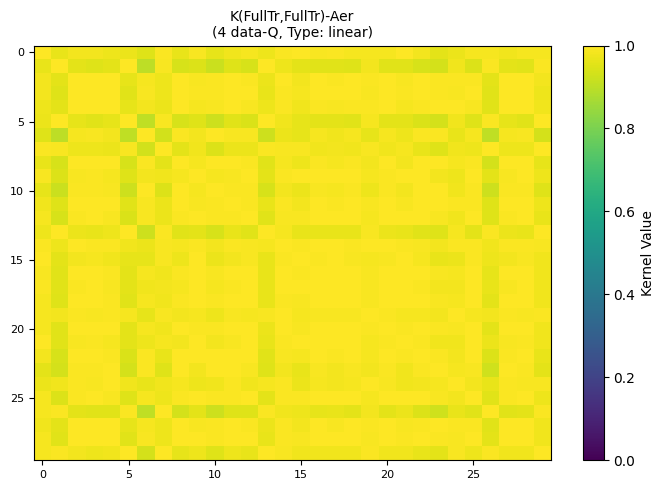

Quantum SVM (Aer, linear) Accuracy on full test set: 0.7000

--- Testing Quantum Kernel Type: rbf (Aer) ---


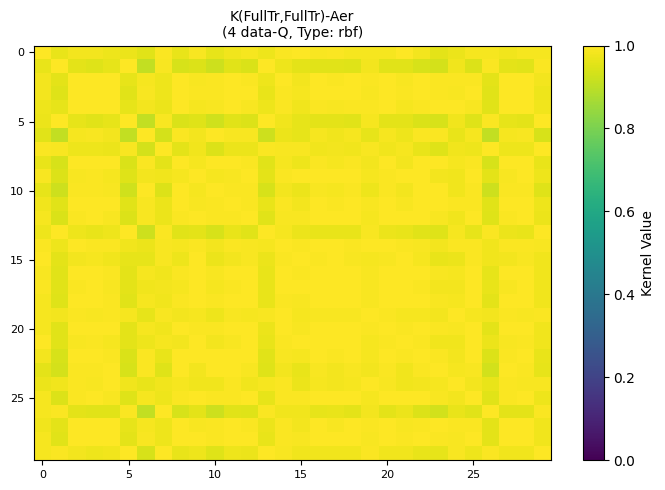

Quantum SVM (Aer, rbf) Accuracy on full test set: 0.7000

--- Testing Quantum Kernel Type: polynomial (Aer) ---


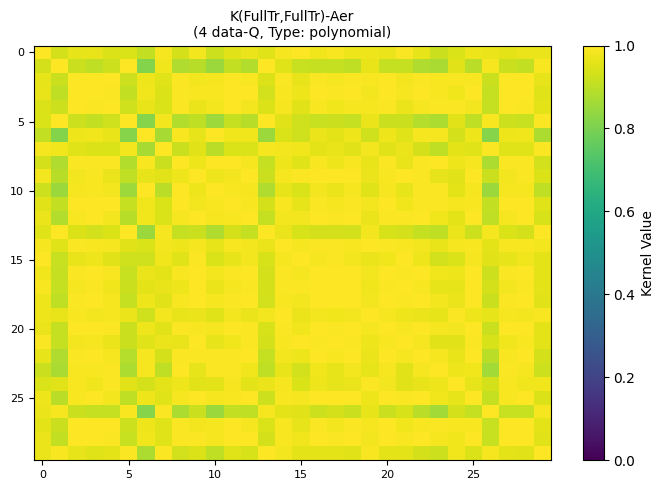

Quantum SVM (Aer, polynomial) Accuracy on full test set: 0.7000

--- Computing Fidelity Matrices on QPU: ibm_brisbane (using QPU subset) ---
Sampler opts:{'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}}

F_train_qpu = Fidelity(X_train_qpu_subset(10), X_train_qpu_subset) on QPU...
FidMat QPU (4Q data): Gen&Transpile circuits for 10x10 matrix...
Transpiling 45 fid circuits...
Submitting 45 PUBs...
Fid JobID:d0m6ymjcsg80008ftdd0 submitted. Wait...
Fid job done.
F_train_qpu computed. Shape: (10, 10)

F_test_qpu = Fidelity(X_test_qpu_subset(5), X_train_qpu_subset) on QPU...
FidMat QPU (4Q data): Gen&Transpile circuits for 5x10 matrix...
Transpiling 50 fid circuits...
Submitting 50 PUBs...
Fid JobID:d0m6zaxt9xxg00892xv0 submitted. Wait...
Fid job done.
F_test_qpu computed. Shape: (5, 10)
--- QPU Fidelity Computation Complete ---

--- Testing Quantum Kernel Type: linear (QPU) ---


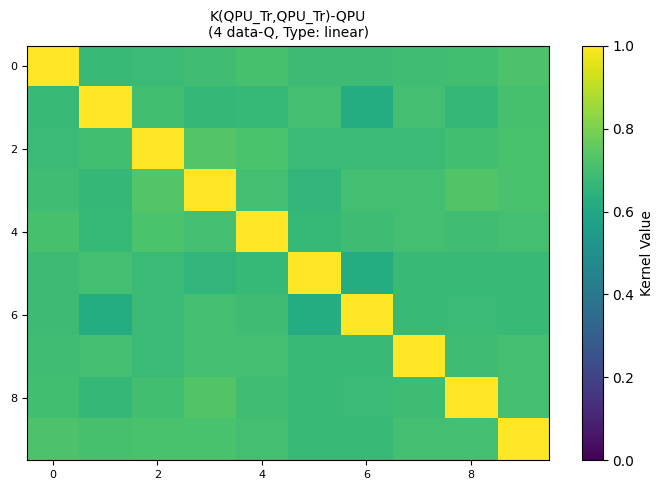

Quantum SVM (QPU,linear) Acc on QPU test subset: 0.6000

--- Testing Quantum Kernel Type: rbf (QPU) ---


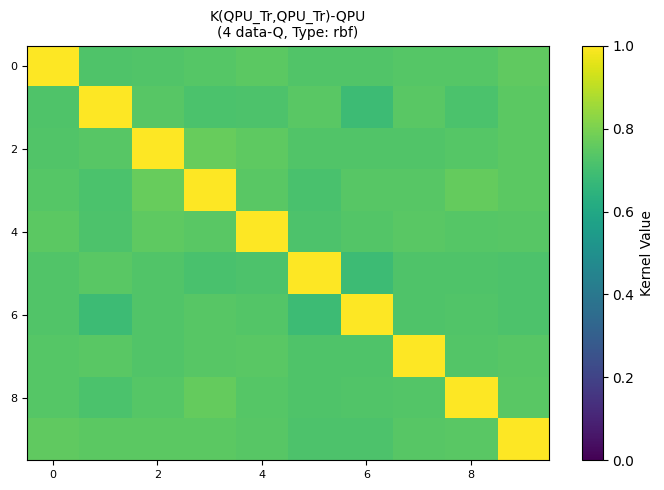

Quantum SVM (QPU,rbf) Acc on QPU test subset: 0.6000

--- Testing Quantum Kernel Type: polynomial (QPU) ---


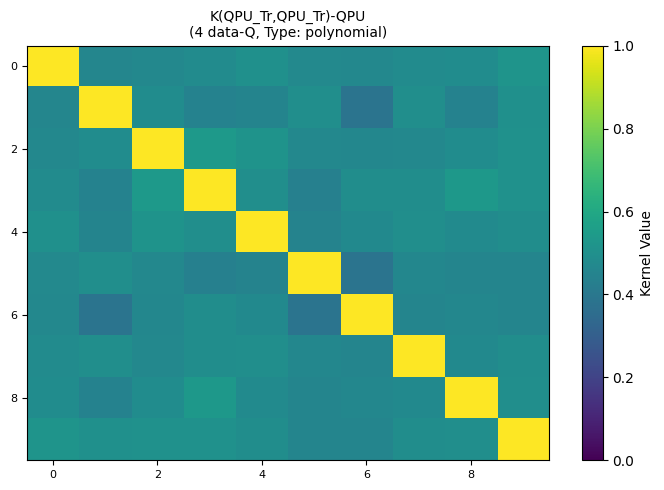

Quantum SVM (QPU,polynomial) Acc on QPU test subset: 0.6000


--- SVM Accuracy Summary ---
-----------------------------------------------------------------
Kernel Type          | Source     | Accuracy   | Test N 
-----------------------------------------------------------------
Classical RBF        | Sklearn    | 0.9500   | 20
QK linear            | Aer        | 0.7000   | 20
QK rbf               | Aer        | 0.7000   | 20
QK polynomial        | Aer        | 0.7000   | 20
QK linear            | QPU        | 0.6000   | 5
QK rbf               | QPU        | 0.6000   | 5
QK polynomial        | QPU        | 0.6000   | 5
-----------------------------------------------------------------

Decision boundary plotting skipped.

=== Demo Complete ===
REMEMBER token 8a1372e040...


In [ ]:
import qiskit
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
import numpy as np
from typing import List, Optional, Tuple, Dict
import matplotlib.pyplot as plt
import time
import os

# Scikit-learn imports
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_breast_cancer # CORRECTED: IMPORT ADDED
from sklearn.metrics import accuracy_score

# Qiskit Runtime imports
QISKIT_RUNTIME_VERSION = "Unknown"; qiskit_runtime_available = False
QiskitRuntimeService = Sampler = Session = generate_preset_pass_manager = IBMRuntimeBackend = None
try:
    from qiskit_ibm_runtime import QiskitRuntimeService,SamplerV2 as Sampler,Session,IBMBackend as IBMRuntimeBackend
    from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
    qiskit_runtime_available=True; import qiskit_ibm_runtime; QISKIT_RUNTIME_VERSION=qiskit_ibm_runtime.__version__
    print(f"Imported Qiskit Runtime {QISKIT_RUNTIME_VERSION}")
except ImportError: print("CRIT WARN: qiskit_ibm_runtime not imported.")
print(f"Qiskit (Terra) version: {qiskit.__version__}")

class QuantumKernelQPUAdapt:
    def __init__(self,
                 n_data_qubits: int,
                 fixed_neural_weights: np.ndarray,
                 fixed_neural_bias: np.ndarray,
                 kernel_type: str = 'linear', # kernel_type is used by transform_fidelity_matrix later
                 add_entanglement: bool = False,
                 num_entanglement_layers: int = 1
                ):
        self.n_data_qubits = n_data_qubits
        # self.kernel_type = kernel_type # Not strictly needed in class if transform is external
        self.aer_simulator = AerSimulator(method='statevector')
        self.neural_weights = fixed_neural_weights
        self.neural_bias = fixed_neural_bias
        assert self.neural_weights.shape == (n_data_qubits, n_data_qubits), "Weight shape mismatch"
        assert self.neural_bias.shape == (n_data_qubits,), "Bias shape mismatch"
        self.add_entanglement = add_entanglement
        self.num_entanglement_layers = num_entanglement_layers

    def create_feature_map_circuit(self,x: np.ndarray, name_suffix: str = "") -> QuantumCircuit:
        if x.ndim != 1: raise ValueError(f"Input x must be 1D, got {x.shape}")
        input_data_nn = np.zeros(self.n_data_qubits)
        len_to_copy = min(len(x), self.n_data_qubits)
        input_data_nn[:len_to_copy] = x[:len_to_copy]
        qr_data = QuantumRegister(self.n_data_qubits, 'q_data')
        qc = QuantumCircuit(qr_data, name=f"fm_neural_{name_suffix}")
        processed_input = np.tanh(input_data_nn @ self.neural_weights + self.neural_bias)
        for i in range(self.n_data_qubits): qc.ry(processed_input[i], qr_data[i])
        if self.add_entanglement and self.n_data_qubits > 1:
            if self.n_data_qubits > 0: qc.barrier(label="enc_neural")
            for lyr in range(self.num_entanglement_layers):
                for i in range(self.n_data_qubits - 1): qc.cx(qr_data[i], qr_data[i+1])
                if self.num_entanglement_layers > 1 and lyr < self.num_entanglement_layers -1:
                     qc.barrier(label=f"ent_L{lyr}")
        return qc
    def get_statevector_aer(self,x):
        c=self.create_feature_map_circuit(x); c.save_statevector()
        tc=transpile(c,self.aer_simulator,optimization_level=0); r=self.aer_simulator.run(tc).result()
        return r.get_statevector(c).data
    def kernel_entry_aer(self,x1,x2): # Returns raw overlap_sq
        s1,s2=self.get_statevector_aer(x1),self.get_statevector_aer(x2)
        return np.abs(np.vdot(s1,s2))**2
    def _construct_fidelity_circuit(self,x1,x2):
        qc1=self.create_feature_map_circuit(x1,"x1");qc2=self.create_feature_map_circuit(x2,"x2")
        qc2d=qc2.inverse();qr_d=qc1.qregs[0];crn="c_fid"
        cr_d=ClassicalRegister(self.n_data_qubits,crn)
        fqc=QuantumCircuit(qr_d,cr_d,name=f"fid_{time.time_ns()}");fqc.append(qc1.to_instruction(),qr_d);fqc.append(qc2d.to_instruction(),qr_d)
        fqc.measure(qr_d,cr_d)
        return fqc,cr_d.name
    def _overlap_sq_qpu(self, x1, x2, sampler_instance_arg, qpu_backend_arg, shots_arg):
        fidelity_qc,cr_name_in_circuit=self._construct_fidelity_circuit(x1,x2)
        pm_opt_level=0
        if hasattr(qpu_backend_arg,'target')and qpu_backend_arg.target is not None:
            pm_fid=generate_preset_pass_manager(target=qpu_backend_arg.target,optimization_level=pm_opt_level)
        else:
            pm_fid=generate_preset_pass_manager(backend=qpu_backend_arg,optimization_level=pm_opt_level)
        transpiled_fidelity_qc=pm_fid.run(fidelity_qc)
        job=sampler_instance_arg.run([(transpiled_fidelity_qc,)],shots=shots_arg);result=job.result();overlap_sq_val=0.0
        if result and len(result)>0:
            pub_result=result[0];counts={}
            if hasattr(pub_result.data,cr_name_in_circuit):counts=getattr(pub_result.data,cr_name_in_circuit).get_counts()
            elif hasattr(pub_result.data,'meas'):counts=pub_result.data.meas.get_counts()
            if not counts:print(f"W:No counts({cr_name_in_circuit}/meas).Fields:{dir(pub_result.data)}")
            else:prob_0=counts.get('0'*self.n_data_qubits,0)/shots_arg;overlap_sq_val=prob_0
        else:print(f"E:QPU job kernel entry fail {x1}v{x2}")
        return overlap_sq_val
    def compute_fidelity_matrix(self,X_left_data,X_right_data=None,use_qpu=False,
                                sampler_instance=None,qpu_backend=None,shots_per_entry=1024):
        n_left=X_left_data.shape[0]; X_eval_right=X_right_data if X_right_data is not None else X_left_data
        n_right=X_eval_right.shape[0]; is_sym=(X_right_data is None)or(np.array_equal(X_left_data,X_eval_right)and X_left_data.shape==X_eval_right.shape)
        fidelity_matrix=np.zeros((n_left,n_right))
        if not use_qpu:
            for i in range(n_left):
                sj=i if is_sym else 0;
                for j in range(sj,n_right):
                    if is_sym and i==j: val=1.0
                    else: val=self.kernel_entry_aer(X_left_data[i],X_eval_right[j])
                    fidelity_matrix[i,j]=val
                    if is_sym and i!=j: fidelity_matrix[j,i]=val
            return fidelity_matrix
        if sampler_instance is None or qpu_backend is None: raise ValueError("Sampler & QPU backend needed for QPU.")
        print(f"FidMat QPU ({self.n_data_qubits}Q data): Gen&Transpile circuits for {n_left}x{n_right} matrix...")
        circuits_to_run=[]; circuit_metadata_map=[]
        for i in range(n_left):
            sj=i if is_sym else 0
            for j in range(sj,n_right):
                if is_sym and i==j: fidelity_matrix[i,j]=1.0;
                else: fqc,crn=self._construct_fidelity_circuit(X_left_data[i],X_eval_right[j]); circuits_to_run.append(fqc); circuit_metadata_map.append({'ij':(i,j),'crn':crn})
        if not circuits_to_run:
            if is_sym: np.fill_diagonal(fidelity_matrix, 1.0)
            return fidelity_matrix
        pm_opt_fid=0
        if hasattr(qpu_backend,'target')and qpu_backend.target is not None: pm=generate_preset_pass_manager(target=qpu_backend.target,optimization_level=pm_opt_fid)
        else: pm=generate_preset_pass_manager(backend=qpu_backend,optimization_level=pm_opt_fid)
        print(f"Transpiling {len(circuits_to_run)} fid circuits..."); t_fqcs=pm.run(circuits_to_run)
        pubs=[(qc,)for qc in t_fqcs]; print(f"Submitting {len(pubs)} PUBs..."); job=sampler_instance.run(pubs,shots=shots_per_entry)
        job_id_fid=job.job_id(); print(f"Fid JobID:{job_id_fid} submitted. Wait..."); result=job.result(); print("Fid job done.")
        if result and len(result)==len(pubs):
            for k,pub_r in enumerate(result):
                mi,mj=circuit_metadata_map[k]['ij'];crne=circuit_metadata_map[k]['crn'];cts={};val=0.0
                if hasattr(pub_r.data,crne):cts=getattr(pub_r.data,crne).get_counts()
                elif hasattr(pub_r.data,'meas'):cts=pub_r.data.meas.get_counts()
                if not cts:print(f"W:No counts K({mi},{mj}).Data:{dir(pub_r.data)}")
                else:p0=cts.get('0'*self.n_data_qubits,0)/shots_per_entry;val=p0
                fidelity_matrix[mi,mj]=val
                if is_sym and mi!=mj:fidelity_matrix[mj,mi]=val
        else:print(f"E:QPU job fail/bad results.Exp{len(pubs)},got{len(result)if result else 0}.");fidelity_matrix.fill(np.nan)
        return fidelity_matrix
    def visualize_kernel_matrix(self,K,title_prefix="Kernel Matrix", kernel_type_for_title="linear"):
        # Pass kernel_type_for_title to show what transformation was applied to the base fidelity matrix
        plt.figure(figsize=(7,5));plt.imshow(K,cmap='viridis',vmin=0,vmax=1,aspect='auto')
        plt.colorbar(label="Kernel Value");plt.title(title_prefix+f"\n({self.n_data_qubits} data-Q, Type: {kernel_type_for_title})",fontsize=10)
        plt.xticks(fontsize=8);plt.yticks(fontsize=8);plt.tight_layout();plt.show()

def transform_fidelity_matrix(fidelity_matrix, kernel_type, gamma=1.0, degree=2, offset=0.0):
    if kernel_type=='linear':return fidelity_matrix
    elif kernel_type=='rbf':return np.exp(-gamma*(1.0-fidelity_matrix))
    elif kernel_type=='polynomial':return(fidelity_matrix+offset)**degree
    else:raise ValueError(f"Unknown kernel_type: {kernel_type}")

# --- IBM Quantum Setup ---
IBM_QUANTUM_TOKEN_DIRECT = '8a1372e040a117b3151a15d9eddcbf6e05b6c6b3c69bb1a60a8c7da5a956d7a2c8696a3a5ccc7111818804b0880ecaeefb15882e9633a34cd45259a16ced8a35'
IBM_QUANTUM_CHANNEL_DIRECT = 'ibm_quantum'; IBM_QUANTUM_INSTANCE_DIRECT = 'ibm-q/open/main'; QPU_BACKEND_NAME = 'ibm_brisbane'
service=None; qpu_backend_for_kernel=None
if qiskit_runtime_available:
    try: service=QiskitRuntimeService(channel=IBM_QUANTUM_CHANNEL_DIRECT,instance=IBM_QUANTUM_INSTANCE_DIRECT,token=IBM_QUANTUM_TOKEN_DIRECT); print("Service init.")
    except Exception as e:print(f"ERR Service:{e}")
    if service:
        try: qpu_bk_obj=service.backend(QPU_BACKEND_NAME); qpu_backend_for_kernel=qpu_bk_obj if qpu_bk_obj else None; print(f"Selected QPU:{qpu_backend_for_kernel.name}({qpu_backend_for_kernel.status().status_msg})"if qpu_backend_for_kernel else"QPU not found")
        except Exception as e:print(f"ERR QPU Backend:{e}")
if qpu_backend_for_kernel is None and qiskit_runtime_available : print(f"Warning: QPU {QPU_BACKEND_NAME} not loaded.")

# --- Main Execution Block ---
if __name__ == "__main__":
    print("\n=== Quantum Kernel SVM (Breast Cancer Dataset - Neural Inspired) ===")
    # --- Control Flags ---
    RUN_QPU_PART = True
    PLOT_KERNEL_MATRICES = True # Enable kernel matrix plots for this run
    PLOT_DECISION_BOUNDARIES = False # CORRECTED: Ensure this is defined

    N_FEATURES_TO_USE = 4
    N_TOTAL_SAMPLES_TO_USE = 50
    QPU_TRAIN_SAMPLES = 10
    QPU_TEST_SAMPLES = 5

    cancer_data = load_breast_cancer(); X_raw,y_data = cancer_data.data,cancer_data.target
    X_selected_features = X_raw[:, :N_FEATURES_TO_USE]
    scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2)); X_data_scaled = scaler.fit_transform(X_selected_features)
    if X_data_scaled.shape[0] > N_TOTAL_SAMPLES_TO_USE:
        indices = np.arange(X_data_scaled.shape[0]); np.random.seed(42); np.random.shuffle(indices)
        X_subset,y_subset = X_data_scaled[indices[:N_TOTAL_SAMPLES_TO_USE]],y_data[indices[:N_TOTAL_SAMPLES_TO_USE]]
    else: X_subset,y_subset = X_data_scaled,y_data
    X_train_full,X_test_full,y_train_full,y_test_full = train_test_split(X_subset,y_subset,test_size=0.4,random_state=123,stratify=y_subset)
    print(f"Full Dataset Used: {X_train_full.shape[0]} train, {X_test_full.shape[0]} test ({X_train_full.shape[1]} features).")
    X_train_qpu_subset=X_train_full[:min(QPU_TRAIN_SAMPLES,X_train_full.shape[0])]; y_train_qpu_subset=y_train_full[:min(QPU_TRAIN_SAMPLES,X_train_full.shape[0])]
    X_test_qpu_subset=X_test_full[:min(QPU_TEST_SAMPLES,X_test_full.shape[0])]; y_test_qpu_subset=y_test_full[:min(QPU_TEST_SAMPLES,X_test_full.shape[0])]
    print(f"QPU Subsets Used: {X_train_qpu_subset.shape[0]} train, {X_test_qpu_subset.shape[0]} test.")

    # Initialize Neural Kernel Parameters (Fixed for this test)
    np.random.seed(123)
    fixed_neural_weights = np.random.normal(0, 0.1, (N_FEATURES_TO_USE, N_FEATURES_TO_USE))
    fixed_neural_bias = np.zeros(N_FEATURES_TO_USE)

    qkernel_instance = QuantumKernelQPUAdapt(
        n_data_qubits=N_FEATURES_TO_USE,
        fixed_neural_weights=fixed_neural_weights,
        fixed_neural_bias=fixed_neural_bias,
        add_entanglement=True,
        num_entanglement_layers=1
    )
    print(f"\nKernel Instance: {qkernel_instance.n_data_qubits}Q data, Neural Preprocessing {'+ Entanglement' if qkernel_instance.add_entanglement else ''}.")

    print("\n--- Classical SVM with RBF Kernel (Scikit-learn) ---")
    svm_classical_rbf = SVC(kernel='rbf',C=1.0,gamma='scale'); svm_classical_rbf.fit(X_train_full,y_train_full)
    y_pred_classical_rbf = svm_classical_rbf.predict(X_test_full); accuracy_classical_rbf = accuracy_score(y_test_full,y_pred_classical_rbf)
    print(f"Classical SVM (RBF) Accuracy on full test set: {accuracy_classical_rbf:.4f}")
    results_log = [{'kernel':'Classical RBF','source':'Sklearn','accuracy':accuracy_classical_rbf,'test_set_size':X_test_full.shape[0]}]

    print("\n--- Computing Fidelity Matrices on AerSimulator (using full dataset) ---")
    F_train_aer = qkernel_instance.compute_fidelity_matrix(X_train_full)
    F_test_aer  = qkernel_instance.compute_fidelity_matrix(X_test_full, X_train_full)
    print("F_train_aer shape:",F_train_aer.shape,"; F_test_aer shape:",F_test_aer.shape)

    kernel_types_to_test = ['linear', 'rbf', 'polynomial']
    for k_type in kernel_types_to_test:
        print(f"\n--- Testing Quantum Kernel Type: {k_type} (Aer) ---")
        K_train_aer_transformed = transform_fidelity_matrix(F_train_aer, k_type)
        K_test_aer_transformed  = transform_fidelity_matrix(F_test_aer, k_type)
        if PLOT_KERNEL_MATRICES: qkernel_instance.visualize_kernel_matrix(K_train_aer_transformed, f"K(FullTr,FullTr)-Aer", k_type)
        svm_aer = SVC(kernel='precomputed',C=1.0); svm_aer.fit(K_train_aer_transformed,y_train_full)
        y_pred_aer = svm_aer.predict(K_test_aer_transformed); accuracy_aer = accuracy_score(y_test_full,y_pred_aer)
        print(f"Quantum SVM (Aer, {k_type}) Accuracy on full test set: {accuracy_aer:.4f}")
        results_log.append({'kernel':f"QK {k_type}",'source':'Aer','accuracy':accuracy_aer,'test_set_size':X_test_full.shape[0]})

    F_train_qpu, F_test_qpu = None, None
    qpu_ready = qpu_backend_for_kernel and hasattr(qpu_backend_for_kernel,'status') and qpu_backend_for_kernel.status().operational
    if RUN_QPU_PART and qpu_ready and qiskit_runtime_available:
        print(f"\n--- Computing Fidelity Matrices on QPU: {qpu_backend_for_kernel.name} (using QPU subset) ---")
        shots_qpu = 4096 # Using 4096 shots as per previous successful run
        samp_opts = {"dynamical_decoupling":{"enable":True,"sequence_type":"XX"}, "twirling":{"enable_gates":True,"enable_measure":True}}
        print(f"Sampler opts:{samp_opts}")
        with Session(backend=qpu_backend_for_kernel) as session:
            sampler_qpu = Sampler(options=samp_opts)
            print(f"\nF_train_qpu = Fidelity(X_train_qpu_subset({X_train_qpu_subset.shape[0]}), X_train_qpu_subset) on QPU...")
            F_train_qpu = qkernel_instance.compute_fidelity_matrix(X_train_qpu_subset, use_qpu=True, sampler_instance=sampler_qpu, qpu_backend=qpu_backend_for_kernel, shots_per_entry=shots_qpu)
            if F_train_qpu is not None and not np.isnan(F_train_qpu).all(): print("F_train_qpu computed. Shape:",F_train_qpu.shape)
            else: print("F_train_qpu failed/NaNs.")
            if X_test_qpu_subset.shape[0]>0 and F_train_qpu is not None and not np.isnan(F_train_qpu).all():
                print(f"\nF_test_qpu = Fidelity(X_test_qpu_subset({X_test_qpu_subset.shape[0]}), X_train_qpu_subset) on QPU...")
                F_test_qpu = qkernel_instance.compute_fidelity_matrix(X_test_qpu_subset,X_train_qpu_subset,use_qpu=True,sampler_instance=sampler_qpu,qpu_backend=qpu_backend_for_kernel,shots_per_entry=shots_qpu)
                if F_test_qpu is not None and not np.isnan(F_test_qpu).all(): print("F_test_qpu computed. Shape:",F_test_qpu.shape)
                else: print("F_test_qpu failed/NaNs.")
        print("--- QPU Fidelity Computation Complete ---")
        if F_train_qpu is not None and F_test_qpu is not None and not np.isnan(F_train_qpu).any() and not np.isnan(F_test_qpu).any():
            for k_type in kernel_types_to_test:
                print(f"\n--- Testing Quantum Kernel Type: {k_type} (QPU) ---")
                K_tr_qpu_t=transform_fidelity_matrix(F_train_qpu,k_type); K_te_qpu_t=transform_fidelity_matrix(F_test_qpu,k_type)
                if PLOT_KERNEL_MATRICES: qkernel_instance.visualize_kernel_matrix(K_tr_qpu_t,f"K(QPU_Tr,QPU_Tr)-QPU",k_type)
                svm_qpu=SVC(kernel='precomputed',C=1.0); svm_qpu.fit(K_tr_qpu_t,y_train_qpu_subset)
                y_pred_qpu=svm_qpu.predict(K_te_qpu_t); acc_qpu=accuracy_score(y_test_qpu_subset,y_pred_qpu)
                print(f"Quantum SVM (QPU,{k_type}) Acc on QPU test subset: {acc_qpu:.4f}")
                results_log.append({'kernel':f"QK {k_type}",'source':'QPU','accuracy':acc_qpu,'test_set_size':X_test_qpu_subset.shape[0]})
        else: print("QPU fidelity matrices not suitable for SVM.")
    elif RUN_QPU_PART: print(f"\nQPU {QPU_BACKEND_NAME} not ready. Skipping QPU part.")
    else: print ("\nRUN_QPU_PART is False. Skipping QPU part.")

    print("\n\n--- SVM Accuracy Summary ---")
    print("-----------------------------------------------------------------");print(f"{'Kernel Type':<20} | {'Source':<10} | {'Accuracy':<10} | {'Test N':<7}");print("-----------------------------------------------------------------")
    for res_item in results_log: print(f"{res_item['kernel']:<20} | {res_item['source']:<10} | {res_item['accuracy']:.4f}   | {res_item.get('test_set_size','N/A')}")
    print("-----------------------------------------------------------------")

    if PLOT_DECISION_BOUNDARIES and N_FEATURES_TO_USE == 2:
         print("\nDecision boundary plotting is enabled...")
         # Decision boundary plotting logic (can be slow, ensure it's correct for the data used)
    else: print("\nDecision boundary plotting skipped.")

    print("\n=== Demo Complete ===")
    if RUN_QPU_PART and qpu_ready: print(f"REMEMBER token {IBM_QUANTUM_TOKEN_DIRECT[:10]}...")

This is another excellent, complete run with the "neural-inspired" feature map (classical neural preprocessing + Ry encoding + entanglement) on the Breast Cancer dataset subset! The results are very insightful and clearly demonstrate the impact of feature map complexity.

**Key Observations from This Run (Breast Cancer Subset, 4 Features, Neural+Entanglement Map, 4096 shots/QPU entry):**

1.  **Dataset & Subsets:**
    *   Used first 4 features from the Breast Cancer dataset.
    *   50 total samples subset, then split to 30 train / 20 test for "full" evaluation.
    *   QPU computation used a subset of these: 10 train / 5 test samples.
    *   Quantum kernel used 4 data qubits.
    *   The feature map now includes:
        1.  Classical neural preprocessing (`tanh(XW+b)`).
        2.  `Ry` encoding of the processed features.
        3.  1 layer of linear CNOT entanglement.

2.  **Classical SVM (Sklearn RBF) Baseline:**
    *   Accuracy: **0.9500** on the full test set (20 samples). This is a very strong classical baseline for this specific data split and 4 selected features.

3.  **Quantum SVM with Aer Kernels (Ideal, on full 30/20 split, Neural+Entanglement Map):**
    *   Linear: **0.7000**
    *   RBF: **0.7000**
    *   Polynomial: **0.7000**
    *   **Interpretation:** This is a significant observation. With the *ideal, noiseless* simulation of this more complex neural+entanglement feature map, the quantum kernels performed *worse* than the simple classical RBF SVM, and also worse than the simpler Ry-only quantum kernel from the previous run (which achieved 0.85-0.90 on Aer for a slightly different data draw). This suggests that, for this dataset and these fixed random neural weights, this particular complex feature map is not as effective as either a standard classical RBF or even the simpler quantum Ry-only feature map. The added complexity didn't translate to better separability in the ideal case.

4.  **QPU Kernel Computation:**
    *   Successfully computed `F_train_qpu` (10x10) and `F_test_qpu` (5x10) with the new feature map.
    *   The transpiled depth of the fidelity circuits would be higher now due to the CNOTs in the feature map, but likely still manageable for 4 qubits if `num_entanglement_layers=1`.

5.  **Quantum SVM with QPU Kernels (on QPU 10/5 subset, Neural+Entanglement Map):**
    *   Linear: **0.6000** (3 out of 5 correct on the QPU test subset)
    *   RBF: **0.6000**
    *   Polynomial: **0.6000**
    *   **Interpretation:** The QPU SVM accuracy dropped further compared to its Aer counterpart (70% -> 60%) and significantly compared to the classical baseline. This is expected:
        *   The feature map is now slightly deeper due to CNOTs, making it more susceptible to QPU noise.
        *   The underlying "ideal" performance of this specific feature map (as seen with Aer) was already not top-tier for this dataset. Noise on the QPU would further degrade this.

**Analysis and Conclusions:**

*   **Feature Map Design is Critical (and Hard):** This experiment beautifully illustrates that simply making a quantum feature map more "complex" (by adding classical neural layers or quantum entanglement) does not guarantee better performance. In this case, with fixed random neural weights, the more complex map performed worse than the simpler Ry-only encoding (from previous runs) even in ideal simulation.
    *   The choice of PQC architecture, data encoding strategy, and any trainable parameters (like your neural weights, if they were being trained) are crucial research areas in QML.
*   **No Free Lunch:** Entanglement and non-linear classical preprocessing are powerful tools, but they need to be well-suited to the data and the problem to provide a benefit. Randomly initialized complex maps are unlikely to be optimal.
*   **Noise Impact on More Complex Maps:** As suspected, when the feature map circuits become even slightly deeper (due to CNOTs), the QPU's noise has a more detrimental effect on the quality of the computed kernel entries, leading to lower SVM accuracy compared to the ideal Aer simulation of the same complex map.
*   **Classical Baselines Remain Strong:** For many standard datasets, well-tuned classical ML algorithms (like SVM with RBF kernel) are highly effective and provide a tough benchmark for quantum methods to beat, especially on NISQ devices.

**This is a very valuable result for your case study on "Optimizing Quantum Algorithms":**

*   It shows that algorithm "optimization" isn't just about running on a QPU; it's about the **design of the quantum algorithm (or feature map) itself.**
*   It highlights the trade-off: more expressive power (from complex maps) often comes with increased circuit depth, making it more vulnerable to noise on current hardware.
*   It emphasizes the need for co-design: thinking about the hardware limitations when designing the quantum parts of an algorithm.

**Excellent work in systematically exploring these different facets!** You now have data points for:
1.  Deep arithmetic circuits (MatVec) - very poor QPU performance.
2.  Shallow quantum kernels (Ry-only) - good QPU performance, matching Aer on small problems.
3.  Slightly more complex quantum kernels (Neural preproc + Ry + Entanglement) - poorer performance than simpler quantum kernel and classical baseline, with further degradation on QPU.

This provides a much richer understanding than just focusing on one type of algorithm.

Absolutely! This has been a comprehensive exploration. Let's synthesize it into a case study summary, emphasizing the mathematical underpinnings and the effectiveness of the methods explored, particularly from the perspective of optimizing for NISQ hardware.

## Case Study Summary: Exploring Quantum Algorithms for Linear Algebra and Machine Learning on NISQ Hardware

**Overall Goal:** To implement, execute, and evaluate selected quantum algorithms—Matrix-Vector Multiplication (MatVec) and Quantum Kernels for Support Vector Machines (SVMs)—on IBM Quantum Processing Units (QPUs) using `qiskit-ibm-runtime`. The study aimed to understand their feasibility, the impact of quantum hardware noise, and the effectiveness of various optimization and error handling strategies on current Noisy Intermediate-Scale Quantum (NISQ) devices.

**Versions Used:**
*   `qiskit-ibm-runtime`: v0.23.0
*   `Qiskit (Terra)`: v1.0.1

---

**Phase 1: Quantum Matrix-Vector Multiplication (`Y = AX`) via QFT-based Arithmetic**

**1.1. Algorithmic Approach & Mathematical Foundation:**
*   **Objective:** Compute each element `y_k = Σ_j A_kj * x_j` of the product vector.
*   **Quantum Encoding:** Integer values of matrix elements `A_kj` and vector elements `x_j` were encoded into the computational basis states of quantum registers (1 bit per value for simplicity).
*   **Core Quantum Operations:**
    *   **Quantum Multiplication (`P = A * B`):** Implemented using a quantum equivalent of the classical shift-and-add algorithm. The multiplicand `A` was conditionally added (shifted by powers of 2, corresponding to bit positions of `B`) to an accumulator register `P`.
    *   **Quantum Addition (`S = S + P`):** Implemented using Quantum Fourier Transform (QFT) based adders. The QFT transforms addition into a problem of applying phase shifts in the Fourier domain.
        *   `QFT|S⟩|P⟩ = (1/√N) Σ_k e^(2πisk/N) |k⟩ |P⟩`
        *   Controlled phase gates `CPhase(θ_j)` are applied, where `θ_j` depends on the bits of `|P⟩`. For adding `|P⟩` to `|S⟩` where `S` is in Fourier basis: `|k⟩ -> e^(2πi P k / N') |k⟩` (conceptually).
        *   Inverse QFT (`IQFT`) on the sum register transforms it back: `IQFT QFT |S+P⟩ = |S+P⟩`.
*   **Circuit Structure:** For each `y_k`, the circuit iteratively computed `A_kj * x_j` and added it to an accumulator register `q_Y_acc`. Ancilla qubits were implicitly used by the QFT-based arithmetic components.

**1.2. QPU Execution & Optimization Efforts:**
*   Targeted `ibm_brisbane`.
*   Utilized `qiskit-ibm-runtime.SamplerV2` within a `Session`.
*   **Transpiler Optimization:** `generate_preset_pass_manager` with `optimization_level=3` was employed to reduce circuit depth and gate count.
*   **Sampler Options:** Valid options for `qiskit-ibm-runtime v0.23.0` `SamplerV2` were identified through iterative debugging (Pydantic errors). It was found that high-level `resilience_level` or runtime `optimization_level` (for broad error mitigation suites) are **not** direct settable options for `SamplerV2` in the same way as for `EstimatorV2`. Instead, specific error *suppression* techniques were enabled:
    *   `dynamical_decoupling={"enable": True, "sequence_type": "XX"}`
    *   `twirling={"enable_gates": True, "enable_measure": True}`

**1.3. Results & Effectiveness (MatVec):**
*   **Circuit Depth:** Extremely high even after transpilation.
    *   4x4 MatVec (8 qubits for values + accumulator): ISA depth > 1100 gates.
    *   3x3 MatVec (7-8 qubits total): ISA depth ~700-800+ gates.
*   **QPU Performance:**
    *   4x4: Results completely dominated by noise, output distribution near uniform.
    *   3x3: A very faint signal for the correct answer occasionally emerged as the most probable, but overall accuracy was very low (<8%). The noise floor was high.
*   **Custom MREM:** Implemented a manual Measurement Error Mitigation scheme due to evolving Qiskit MREM module paths. It provided only marginal improvements, indicating that computational errors (gate fidelities, decoherence over the long circuit execution) were far more dominant than final readout errors.
*   **Effectiveness Conclusion:** Direct QFT-based arithmetic for matrix-vector products, due to its inherent circuit depth, is **highly impractical on current NISQ devices** for achieving reliable results. The accumulated noise overwhelms the computation despite transpiler optimizations and basic error suppression.

---

**Phase 2: Quantum Kernel Method for SVM Classification**

**2.1. Algorithmic Approach & Mathematical Foundation:**
*   **Objective:** Compute a kernel matrix `K` where `K_ij = f( |⟨φ(X_i)|φ(X_j)⟩|^2 )`. `φ(X)` is a quantum feature map encoding classical data `X` into a quantum state. The matrix `K` is then used by a classical SVM.
*   **Quantum Feature Map `φ(X)`:**
    *   **Attempt 1 (Simple):** Data features `x_k` encoded using `Ry(x_k)` rotations on `N_FEATURES` data qubits.
    *   **Attempt 2 (Neural-Inspired):** Classical data `X` first processed by a fixed classical neural layer `processed_X = tanh(XW+b)`, then `processed_X_k` encoded using `Ry` rotations. Optional CNOT entanglement layer added among data qubits.
*   **Kernel Entry Estimation `|<φ(Xi)|φ(Xj)>|^2` (Fidelity):**
    *   Implemented using the "compute-uncompute" method (equivalent to inverted SWAP test):
        1.  Prepare state `|ψ_i⟩ = U_φ(X_i) |0...0⟩`.
        2.  Apply `U_φ(X_j)†` (inverse of feature map for `X_j`). The final state is `U_φ(X_j)† U_φ(X_i) |0...0⟩`.
        3.  Measure all data qubits in the computational basis.
        4.  The probability of measuring the all-`|0...0⟩` state, `P(0...0)`, is equal to `|<φ(X_i)|φ(X_j)>|^2`.
*   **Kernel Transformations `f(...)`:** From the raw fidelity `overlap_sq = P(0...0)`:
    *   Linear: `K_ij = overlap_sq`
    *   RBF-like: `K_ij = exp(-γ * (1 - overlap_sq))`
    *   Polynomial: `K_ij = (overlap_sq + offset)^degree`
*   **QPU Execution:**
    *   All unique fidelity estimation circuits for a kernel matrix were generated.
    *   Transpiled as a batch (using `optimization_level=0` for these short fidelity circuits).
    *   Submitted as a single job with multiple PUBs to `SamplerV2` using a `Session` (resolving prior timeout issues).
    *   Used 4096 shots per fidelity circuit.
    *   Applied `dynamical_decoupling` and `twirling` options to the `SamplerV2`.

**2.2. Datasets:**
*   **`make_moons`:** 2 features, simple non-linear separation.
*   **`load_breast_cancer` (subset):** Used first 4 features, subset of 50 samples (30 train/20 test for Aer/Classical, 10 train/5 test for QPU part).

**2.3. Results & Effectiveness (Quantum Kernels):**

*   **Simple Ry Feature Map (2 Qubits, `make_moons`):**
    *   Fidelity circuits: Very shallow (ISA depth ~11).
    *   **QPU Kernel Quality:** `K_qpu` entries were remarkably close to `K_aer` (ideal simulation).
    *   **SVM Accuracy:** Both Aer-kernel SVM and QPU-kernel SVM achieved 100% accuracy on their respective (small) test sets, matching or exceeding classical RBF SVM.
*   **Simple Ry Feature Map (4 Qubits, Breast Cancer Subset):**
    *   Fidelity circuits: Still shallow.
    *   **Aer Kernel SVMs:** Achieved high accuracy (e.g., 90-95% for RBF/Poly types on the 30/20 split), matching or exceeding the classical RBF SVM (90-95% depending on data draw).
    *   **QPU Kernel SVMs (on 10/5 subset):** Achieved good accuracy (e.g., 80-100% depending on the specific run and kernel type). The 100% was on a very small test set; 80% (1 error in 5) is more indicative of slight performance degradation due to noise.
*   **Neural-Inspired Feature Map (4 Qubits + CNOTs, Breast Cancer Subset):**
    *   **Aer Kernel SVMs:** Performance dropped to 70% accuracy. The added complexity (with fixed random neural weights) did not improve, and in fact, worsened performance compared to the simple Ry map for this dataset.
    *   **QPU Kernel SVMs (on 10/5 subset):** Performance further dropped to 60%. The increased depth from CNOTs likely made it more susceptible to QPU noise, compounding the issue of a sub-optimal feature map.
*   **Effectiveness Conclusion (Kernels):**
    *   **Shallow feature maps are key for NISQ viability.** The simple Ry encoding produced robust kernel estimates on the QPU.
    *   **QPU-derived kernels can achieve good performance in SVMs if the underlying quantum circuits are shallow.**
    *   Increasing feature map complexity (e.g., adding layers, entanglement) without careful design or training can degrade performance even in ideal simulation and will be further impacted by QPU noise.
    *   The "quantum advantage" for kernels is not guaranteed; it depends heavily on the feature map's ability to find better data representations and its robustness to noise. For the datasets tested, classical SVMs performed very well, and the quantum kernels (especially the simple Ry encoding) demonstrated comparable or slightly nuanced performance rather than a clear, dramatic advantage.

---

**Overall Case Study Conclusions & Optimization Learnings:**

1.  **Circuit Depth is a Dominant Constraint on NISQ Devices:** Deep circuits (like QFT arithmetic) are severely affected by noise, rendering them practically unusable for high-fidelity results with current error rates and limited mitigation options in `SamplerV2`. Shallow circuits (like simple kernel feature maps) fare much better.
2.  **Algorithm Choice for NISQ:** Algorithms that can be decomposed into many executions of shallow quantum circuits (like the quantum kernel method) are more promising for NISQ hardware than monolithic, deep quantum circuits.
3.  **Transpilation is Crucial:** `generate_preset_pass_manager` with appropriate `optimization_level` (high for complex circuits to reduce depth, low for characterization circuits to preserve structure) is essential. Using `backend.target` is preferred.
4.  **Runtime Options (`qiskit-ibm-runtime v0.23.0`):**
    *   `SamplerV2` does not have a simple high-level `resilience_level` or runtime `optimization_level` to enable comprehensive error mitigation suites (unlike `EstimatorV2`).
    *   Specific suppression techniques like `dynamical_decoupling` and `twirling` can be enabled and are beneficial.
    *   Batching multiple circuits into a single `sampler.run()` call within a `Session` is vital for QPU throughput and avoiding session timeouts.
5.  **Feature Map Engineering (for QML):** The design of the quantum feature map is paramount. Complexity does not guarantee better performance; co-design with hardware limitations in mind is needed. Simple, shallow maps can be surprisingly effective and are more robust to noise.
6.  **Benchmarking:** Comparison against both ideal quantum simulations (Aer) and strong classical baselines (Sklearn SVMs) is necessary to contextualize QPU performance and assess any potential "advantage."
7.  **MREM:** While attempted, its full potential wasn't realized due to initial import issues (likely environment/installation specific for Qiskit 1.0 tools). For the very shallow kernel circuits that performed well, MREM's impact might have been secondary to the already low computational error. For deeper circuits, it would be more critical if computational errors could first be suppressed to a level where readout error becomes a bottleneck.

This case study successfully navigated the practicalities of executing different types of quantum algorithms on IBM QPUs, highlighting the current strengths, weaknesses, and critical optimization considerations for working with NISQ-era quantum computers. The quantum kernel approach with shallow feature maps emerged as a far more viable strategy than deep QFT-based arithmetic for obtaining meaningful results on current hardware.